# Ensemble of predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

In [2]:
preds = pd.read_csv('../output/pred_DAX_2015_2019_4yw30_4yw20_4yw10.csv',
                    delimiter=',')
preds.head(3)

,Date,actual,4yw30,4yw20,4yw10,avg,avg_diff,median,med_diff,winner
0,2015-02-13,10963.40,11046.69,11046.69,11046.69,11046.69,8782.58,11046.69,8782.58,4yw30
1,2015-02-16,10923.23,10964.83,10964.83,10964.83,10964.83,8740.89,10964.83,8740.89,4yw30
2,2015-02-17,10895.62,10953.37,10953.37,10953.37,10953.37,8757.04,10953.37,8757.04,4yw30


#### Plot the predictions made by each network, together with the actual value. Compute the MAE for each prediction, and display it in the title of the plot.

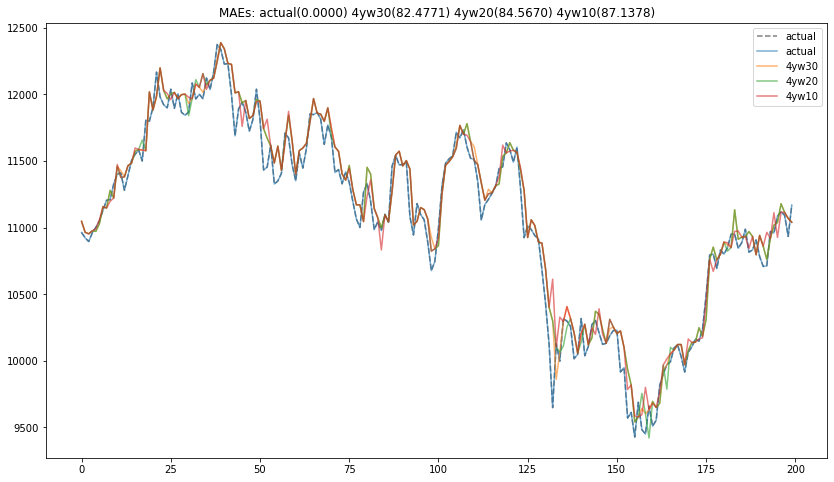

In [3]:
num_preds = preds.columns.get_loc('avg')-1
show_only = 200

plt.figure(figsize=(14,8))
plt.plot(preds.actual.iloc[:show_only], 'k--', alpha=0.5, label='actual')
mae = list()
for i in range(num_preds):
    plt.plot(preds.iloc[:show_only][preds.columns[i+1]], alpha=0.6, label=preds.columns[i+1])
    mae.append('{:.4f}'.format(mean_absolute_error(preds['actual'], preds[preds.columns[i+1]])))

maes=''
for e in list(zip(preds.columns[1:num_preds+1], mae)):
    maes += ' {}({})'.format(e[0], e[1])
plt.title('MAEs:{}'.format(maes))
plt.legend()
plt.show()

### Compute weights

Compute a simple matrix with the proportion of times that each network is performing as the best one.

The weights of each network is computed according to the following expresion:

$$ w^{(j)} = \frac{NP}{TP} $$

where $NP$ is the _number of positives_ predictions, or number of times each network is the one that produces the best prediction among the rest of networks. And $TP$ is the _total number of predictions_ present in the series.

In [5]:
net_names = preds.columns[2:num_preds+1]
print('Net names: {}'.format(net_names))
proportions = preds.winner.value_counts()
weights = pd.DataFrame({'proportion': proportions, 'weight': pd.Series(index=proportions.index)})
weights.weight = weights.proportion / weights.proportion.sum()
weights

Net names: Index(['4yw30', '4yw20', '4yw10'], dtype='object')


,proportion,weight
4yw30,917,0.770588
4yw10,165,0.138655
4yw20,108,0.090756


Add a new column with the weighted average of each prediction.

$$ \overline{p_i} = \sum_{j=1}^N p_{i}^{(j)} \cdot w^{(j)} $$

where $\overline{p_i}$ is the $i^{ith}$ weighted average prediction in the series, $N$ is the number of networks used, or the number of existing predictions to be weightedly averaged. $ p_{i}^{(j)}$ is the $i^{ith}$ prediction in the series produced by the $ j^{th} $ network (among the existing $N$ networks), and $ w^{(j)} $ is the weight of the $ j^{th} $ network, or its percentage of success.

In [6]:
preds['w_avg'] = sum([preds[net] * weights.loc[net].weight for net in net_names])

Plot the final ensemble value `w_avg` computing also its MAE.

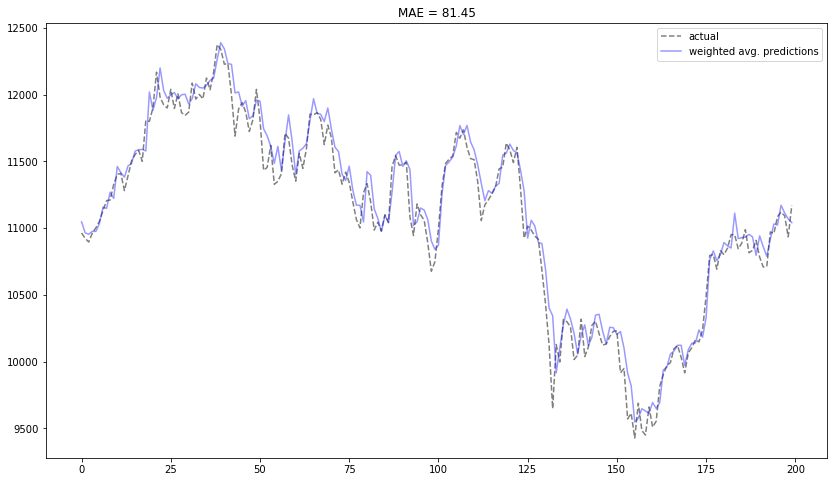

In [7]:
mae = mean_absolute_error(preds['actual'], preds['w_avg'])

plt.figure(figsize=(14,8))
plt.plot(preds.iloc[:show_only]['actual'], 'k--', alpha=0.5, label='actual')
plt.plot(preds.iloc[:show_only]['w_avg'], 'b-', alpha=0.4, label='weighted avg. predictions')
plt.title('MAE = {:.2f}'.format(mae))
plt.legend()
plt.show()

### Correlation

This plot simply illustrates the correlation between the actual values in the time series and the forecasts made by the ensemble. The points along the diagonal show strong correlation, which is a good sign. If points spread along a cloud of points means that predictions are completely random.

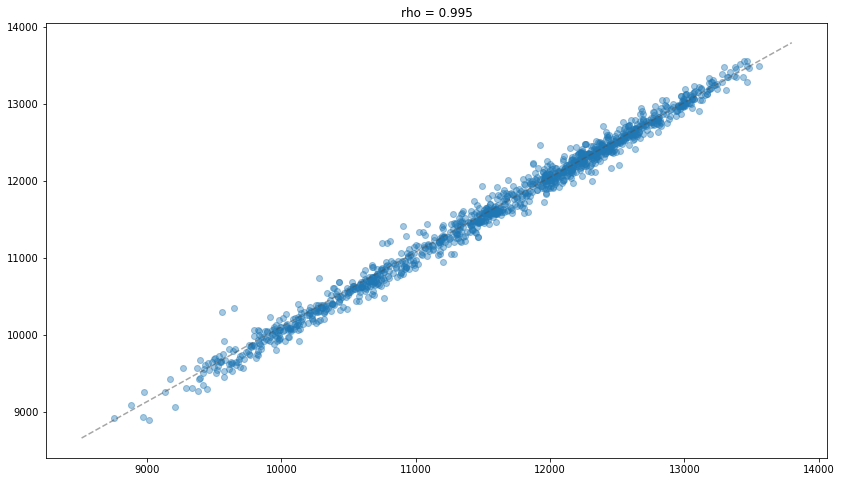

In [8]:
plt.figure(figsize=(14,8))
plt.scatter(preds.actual, preds['w_avg'], alpha=0.4)
plt.plot(plt.xlim(), plt.ylim(), ls='--', c='.3', alpha=0.5)
plt.title('rho = {:.3f}'.format(pearsonr(preds.actual, preds['w_avg'])[0]))
plt.show()

Compute the correlation with previous values in the time Series. This plot shows how dependent is the prediction on previous values in the time series. The X axis shows the distance between the prediction and its previous values, being "1" the value exactly before in the series, "2" the value previous to the last known value, etc.

We can see that the prediction is very much related to the last value. It is the most important one. However, its relative strength compared with the other values, though greater, is not extremely important. Ideally this line should show a gradual negative slope, withou spikes.

In [9]:
corrs = []
for shift in range(1, 11):
    starting_point = 10
    end_point = preds.shape[0]
    lower_limit = starting_point - shift
    upper_limit = end_point - shift
    p = pearsonr(preds.iloc[starting_point:end_point]['w_avg'], 
                 preds.iloc[lower_limit:upper_limit]['actual'])[0]
    corrs.append(p)

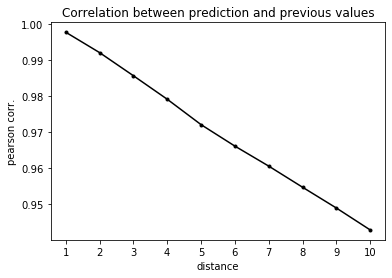

In [10]:
plt.plot(range(1, 11), corrs, 'k.-')
plt.xticks(range(1,11))
plt.title('Correlation between prediction and previous values')
plt.xlabel('distance')
plt.ylabel('pearson corr.')
plt.show()

In [11]:
preds.head()

,Date,actual,4yw30,4yw20,4yw10,avg,avg_diff,median,med_diff,winner,w_avg
0,2015-02-13,10963.40,11046.69,11046.69,11046.69,11046.69,8782.58,11046.69,8782.58,4yw30,11046.690000
1,2015-02-16,10923.23,10964.83,10964.83,10964.83,10964.83,8740.89,10964.83,8740.89,4yw30,10964.830000
2,2015-02-17,10895.62,10953.37,10953.37,10953.37,10953.37,8757.04,10953.37,8757.04,4yw30,10953.370000
3,2015-02-18,10961.00,10975.94,10975.94,10975.94,10975.94,8714.23,10975.94,8714.23,4yw30,10975.940000
4,2015-02-19,11001.94,10972.06,10972.06,10993.47,10979.20,8722.03,10975.63,8725.60,4yw10,10975.028613


# Weighted Median results

This experiment measures what is the MAE with weighted median, instead of weighted average.

In [12]:
def weighted_median(data, weights):
    """
    Args:
      data (list or numpy.array): data
      weights (list or numpy.array): weights
    """
    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

net_names = list(net_names)
w = np.array(weights.weight.values)
preds['w_med'] = preds[net_names].apply(lambda row: weighted_median(row, w), axis=1)

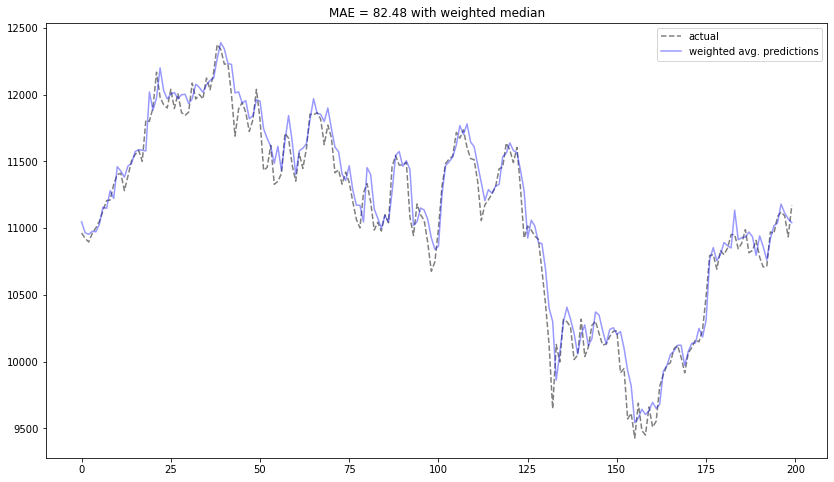

In [13]:
mae = mean_absolute_error(preds['actual'], preds['w_med'])

plt.figure(figsize=(14,8))
plt.plot(preds.iloc[:show_only]['actual'], 'k--', alpha=0.5, label='actual')
plt.plot(preds.iloc[:show_only]['w_med'], 'b-', alpha=0.4, label='weighted avg. predictions')
plt.title('MAE = {:.2f} with weighted median'.format(mae))
plt.legend()
plt.show()

# 6-window LSTM training

This test is measuring what is the MAE when training 6 different pairs of LSTM to produce predictions and ensembles.

In [4]:
preds6 = pd.read_csv('/Users/renero/code/trader/output/^GDAXI/pred_DAX_2018_2019_4yw60_4yw50_4yw40_4yw30_4yw20_4yw10.csv',
                    delimiter=',')
preds6.head(3)

,Date,actual,4yw60,4yw50,4yw40,4yw30,4yw20,4yw10,avg,avg_diff,median,med_diff,winner
0,2018-03-27,11970.83,11987.72,11900.69,11900.69,11900.69,11823.33,11900.69,11902.30,10347.73,11900.69,10349.34,4yw60
1,2018-03-28,11940.71,12039.91,12028.42,12028.42,12028.42,12028.42,12085.86,12039.91,10378.40,12028.42,10366.91,4yw50
2,2018-03-29,12096.73,11956.39,12020.77,12020.77,12020.77,11925.39,11963.54,11984.61,10391.32,11984.61,10391.32,4yw50


Plot all the predictions together with their respective MAEs.

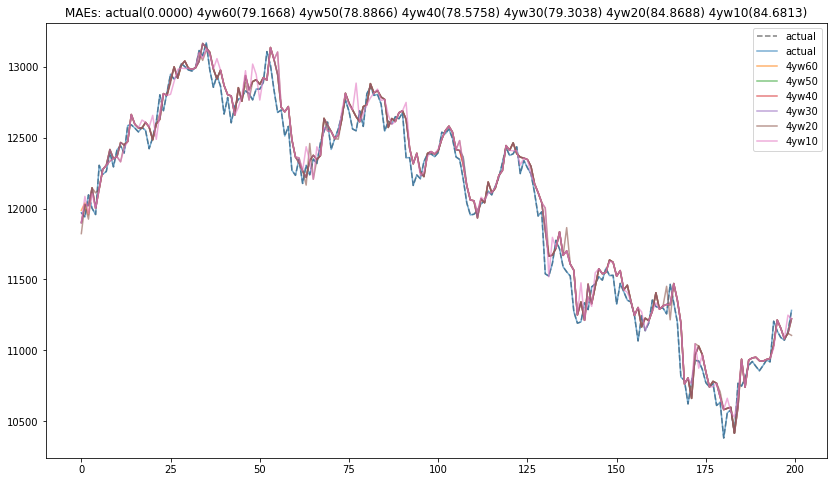

In [8]:
num_preds = preds6.columns.get_loc('avg')-1
show_only = 200

plt.figure(figsize=(14,8))
plt.plot(preds6.actual.iloc[:show_only], 'k--', alpha=0.5, label='actual')
mae = list()
for i in range(num_preds):
    plt.plot(preds6.iloc[:show_only][preds6.columns[i+1]], alpha=0.6, label=preds6.columns[i+1])
    mae.append('{:.4f}'.format(mean_absolute_error(preds6['actual'], preds6[preds6.columns[i+1]])))

maes=''
for e in list(zip(preds6.columns[1:num_preds+1], mae)):
    maes += ' {}({})'.format(e[0], e[1])
plt.title('MAEs:{}'.format(maes))
plt.legend()
plt.show()

Compute weights and plot weighted average

In [14]:
net_names = preds6.columns[2:num_preds+1]
print('Net names: {}'.format(net_names))
proportions = preds6.winner.value_counts()
weights = pd.DataFrame({'proportion': proportions, 'weight': pd.Series(index=proportions.index)})
weights.weight = weights.proportion / weights.proportion.sum()
weights

Net names: Index(['4yw60', '4yw50', '4yw40', '4yw30', '4yw20', '4yw10'], dtype='object')


,proportion,weight
4yw60,272,0.658596
4yw10,64,0.154964
4yw20,40,0.096852
4yw30,15,0.036320
4yw50,14,0.033898
4yw40,8,0.019370


Net names: Index(['4yw60', '4yw50', '4yw40', '4yw30', '4yw20', '4yw10'], dtype='object')


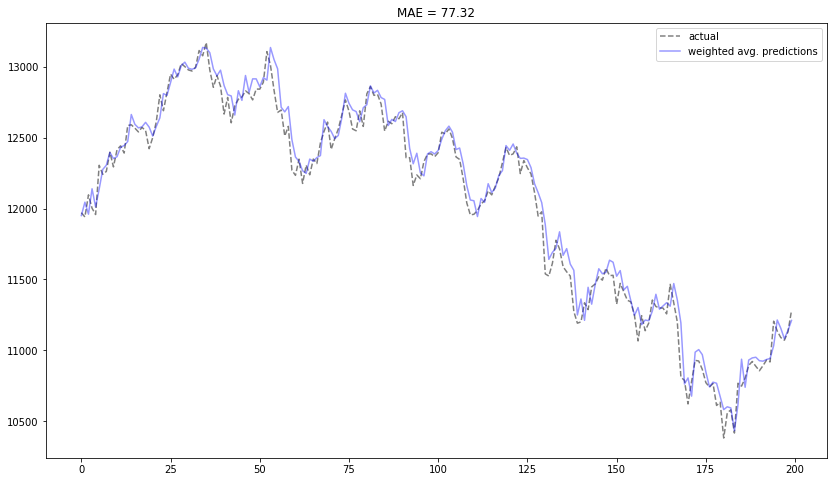

In [13]:
preds6['w_avg'] = sum([preds6[net] * weights.loc[net].weight for net in net_names])
mae = mean_absolute_error(preds6['actual'], preds6['w_avg'])

plt.figure(figsize=(14,8))
plt.plot(preds6.iloc[:show_only]['actual'], 'k--', alpha=0.5, label='actual')
plt.plot(preds6.iloc[:show_only]['w_avg'], 'b-', alpha=0.4, label='weighted avg. predictions')
plt.title('MAE = {:.2f}'.format(mae))
plt.legend()
plt.show()

## With 6 windows, MAE decreases from 82.48 to 77.32